# GPU bug report

In [3]:
!git clone https://github.com/joacorapela/svGPFA.git

Cloning into 'svGPFA'...
remote: Enumerating objects: 11679, done.
remote: Counting objects: 100% (2547/2547), done.
remote: Compressing objects: 100% (877/877), done.
remote: Total 11679 (delta 1556), reused 2473 (delta 1488), pack-reused 9132
Receiving objects: 100% (11679/11679), 323.67 MiB | 25.83 MiB/s, done.
Resolving deltas: 100% (7097/7097), done.
Updating files: 100% (293/293), done.


In [7]:
%cd svGPFA

/content/svGPFA


In [11]:
!git branch -a

* master
  remotes/origin/HEAD -> origin/master
  remotes/origin/autogradJAX
  remotes/origin/changeOptimStrategy
  remotes/origin/changeOptimStrategyMAP
  remotes/origin/cholForPIndPoints
  remotes/origin/develop
  remotes/origin/firstRefactorPlusSVFrontEnd
  remotes/origin/gh-pages
  remotes/origin/master
  remotes/origin/olderSVEMwithNewerCode
  remotes/origin/optimAllParamsSimultaneously
  remotes/origin/pseudoInverse
  remotes/origin/scipyOptimize
  remotes/origin/scipyOptimizeWithHessian
  remotes/origin/scipyOptimizeWithHessianMAP
  remotes/origin/simultaneousEStepAndMStepKernels


In [10]:
!git checkout optimAllParamsSimultaneouslyCUDA

error: pathspec 'optimAllParamsSimultaneouslyCUDA' did not match any file(s) known to git


## Import requirements

In [ ]:
import os
import traceback
import random
import pickle
import configparser
import torch
import plotly.graph_objects as go

import gcnu_common.utils.config_dict
import svGPFA.stats.svGPFAModelFactory
import svGPFA.stats.svEM
import svGPFA.utils.configUtils
import svGPFA.utils.miscUtils
import svGPFA.utils.initUtils

## Configuration parameters

In [ ]:
sim_res_number = 91450833
est_init_number = 551
n_repeats = 1
cuda_device_index = 0
est_init_config_filename_pattern = "../data/{:08d}_estimation_metaData.ini"
sim_res_config_filename_pattern = "../results/{:08d}_simulation_metaData.ini"

# Load data

In [ ]:
sim_res_config_filename = sim_res_config_filename_pattern.format(
    sim_res_number)
sim_res_config = configparser.ConfigParser()
sim_res_config.read(sim_res_config_filename)
sim_res_filename = sim_res_config["simulation_results"]["sim_res_filename"]
with open(sim_res_filename, "rb") as f:
    sim_res = pickle.load(f)
spikes_times = sim_res["spikes_times"]
n_trials = len(spikes_times)
n_neurons = len(spikes_times[0])

spikes_times = [[spikes_times[r][n].tolist() for n in range(n_neurons)]
                for r in range(n_trials)]

sim_init_config_filename = sim_res_config["simulation_params"]["sim_init_config_filename"]
sim_init_config = configparser.ConfigParser()
sim_init_config.read(sim_init_config_filename)
trials_start_times = [float(str) for str in sim_init_config["data_structure_params"]["trials_start_times"][1:-1].split(",")]
trials_end_times = [float(str) for str in sim_init_config["data_structure_params"]["trials_end_times"][1:-1].split(",")]

est_init_config_filename = est_init_config_filename_pattern.format(
    est_init_number)
est_init_config = configparser.ConfigParser()
est_init_config.read(est_init_config_filename)
n_latents = int(est_init_config["model_structure_params"]["n_latents"])

## Build parameters

### Build configuration file parameter specifications

In [ ]:
args_info = svGPFA.utils.initUtils.getArgsInfo()
strings_dict = gcnu_common.utils.config_dict.GetDict(
    config=est_init_config).get_dict()
config_file_params = svGPFA.utils.initUtils.getParamsDictFromStringsDict(
    n_latents=n_latents, n_trials=n_trials, strings_dict=strings_dict,
    args_info=args_info)

### Build default parameter specificiations

In [ ]:
default_params = svGPFA.utils.initUtils.getDefaultParamsDict(
    n_neurons=n_neurons, n_trials=n_trials, n_latents=n_latents)

## Perform estimations

In [ ]:
# devices = ["cpu", f"cuda:{cuda_device_index}"]
devices = ["cpu"]
elapsed_times = torch.empty((len(devices), n_repeats), dtype=torch.double)
lower_bounds = torch.empty((len(devices), n_repeats), dtype=torch.double)
num_fun_eval = torch.empty((len(devices), n_repeats), dtype=torch.double)
num_iter = torch.empty((len(devices), n_repeats), dtype=torch.double)

for d, device in enumerate(devices):
    r = 0
    while r < n_repeats:
        print(f"Processing device {device}, repeat {r}")
        #    finally, get the parameters from the dynamic,
        #    configuration file and default parameter specifications
        params, kernels_types = svGPFA.utils.initUtils.getParamsAndKernelsTypes(
            n_trials=n_trials, n_neurons=n_neurons, n_latents=n_latents,
            trials_start_times=trials_start_times,
            trials_end_times=trials_end_times,
            dynamic_params_spec={},
            config_file_params_spec=config_file_params,
            default_params_spec=default_params)

        # build kernels
        kernels_params0 = params["initial_params"]["posterior_on_latents"]["kernels_matrices_store"]["kernels_params0"]
        kernels = svGPFA.utils.miscUtils.buildKernels(
            kernels_types=kernels_types, kernels_params=kernels_params0)

        # create model
        kernelMatrixInvMethod = svGPFA.stats.svGPFAModelFactory.kernelMatrixInvChol
        indPointsCovRep = svGPFA.stats.svGPFAModelFactory.indPointsCovChol
        model = svGPFA.stats.svGPFAModelFactory.SVGPFAModelFactory.buildModelPyTorch(
            conditionalDist=svGPFA.stats.svGPFAModelFactory.PointProcess,
            linkFunction=svGPFA.stats.svGPFAModelFactory.ExponentialLink,
            embeddingType=svGPFA.stats.svGPFAModelFactory.LinearEmbedding,
            kernels=kernels, kernelMatrixInvMethod=kernelMatrixInvMethod,
            indPointsCovRep=indPointsCovRep)

        model.setParamsAndData(
            measurements=spikes_times,
            initial_params=params["initial_params"],
            eLLCalculationParams=params["ell_calculation_params"],
            priorCovRegParam=params["optim_params"]["prior_cov_reg_param"])

        model.to(device=device)

        # maximize lower bound
        svEM = svGPFA.stats.svEM.SVEM_PyTorch()
        try:
            lowerBoundHist, elapsedTimeHist, terminationInfo,\
            iterationsModelParams, num_fun_eval[d, r], num_iter[d, r] = \
                svEM.maximizeSimultaneously(model=model,
                                            optim_params=params["optim_params"])
            elapsed_times[d, r] = elapsedTimeHist[-1]
            lower_bounds[d, r] = lowerBoundHist[-1]
        except Exception as e:
            print("Exception detected. Retrying")
            stack_trace = traceback.format_exc()
            print(e)
            print(stack_trace)
        print("Device {:s}, Repeat {:d}: elapsed time {:f}, "
              "elapsed time per function call {:f}, "
              "lower bound {:f}".format(device, r, elapsed_times[d, r],
                                        elapsed_times[d, r]/num_fun_eval[d, r],
                                        lower_bounds[d, r]))
        r += 1


Processing device cpu, repeat 0
Extracted config_file_params_spec[optim_params][n_quad]=200
Extracted config_file_params_spec[ind_points_locs_params0][n_ind_points]=tensor([9, 9], dtype=torch.int32)
Extracted from config_file c0_distribution=Normal, c0_loc=0.0, c0_scale=1.0, c0_random_seed=None
Extracted from config_file d0_distribution=Normal, d0_loc=0.0, d0_scale=1.0, d0_random_seed=None
Extracted from config_file k_type=exponentialQuadratic and k_lengthsales0=2.0
Extracted from config_file ind_points_locs0_layout=uniform
Extracted from config_file variational_mean0_constant_value=0.0
Extracted from config_file variational_cov0_diag_value=0.1
Extracted config_file_params_spec[optim_params][n_quad]=200
Extracted config_file_params_spec[optim_params][prior_cov_reg_param]=0.001
Extracted config_file_params_spec[optim_params][optim_method]=ECM
Extracted config_file_params_spec[optim_params][em_max_iter]=10
Extracted config_file_params_spec[optim_params][verbose]=True
Extracted config_fil

/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning:

posterior variance is larger than the prior variance: k=0, r=8



tensor([-0.1829, -0.1519, -0.0471, -0.1304, -0.3737, -0.2755, -0.1392,  0.5764,
         1.0626])


/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning:

posterior variance is larger than the prior variance: k=1, r=4



tensor([0.3023, 0.1575, 0.1859, 0.2234, 1.5235, 0.3777, 0.1733, 0.1784, 0.0769])
Iteration 01, end: 15813.664215, niter: 71, nfeval: 125
Iteration 02, start: 15813.664215
Iteration 02, end: 20516.243141, niter: 100, nfeval: 106
Iteration 03, start: 20516.243141


/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning:

posterior variance is larger than the prior variance: k=0, r=6



tensor([ 0.1364,  0.0660, -0.0682, -0.0470, -0.0677,  0.0673,  0.1121, -0.1815,
         1.0008])
tensor([ 0.1360,  0.0662, -0.0683, -0.0472, -0.0680,  0.0696,  0.1128, -0.1822,
         1.0022])
tensor([ 0.1354,  0.0664, -0.0686, -0.0471, -0.0681,  0.0732,  0.1137, -0.1834,
         1.0041])
Iteration 03, end: 20632.212469, niter: 100, nfeval: 102
Iteration 04, start: 20632.212469
tensor([ 0.1354,  0.0664, -0.0686, -0.0471, -0.0681,  0.0732,  0.1137, -0.1834,
         1.0041])
Iteration 04, end: 20657.925860, niter: 100, nfeval: 105
Iteration 05, start: 20657.925860
tensor([ 0.1934,  0.1070, -0.1145, -0.0512, -0.0962,  0.1167,  0.1862, -0.2546,
         1.0000])
tensor([ 0.1948,  0.1074, -0.1151, -0.0512, -0.0964,  0.1170,  0.1866, -0.2567,
         1.0001])
tensor([ 0.1959,  0.1078, -0.1154, -0.0512, -0.0965,  0.1172,  0.1868, -0.2582,
         1.0002])
tensor([ 0.1966,  0.1080, -0.1156, -0.0511, -0.0965,  0.1172,  0.1868, -0.2591,
         1.0002])
tensor([ 0.1988,  0.1087, -0.1160,

## Plot results

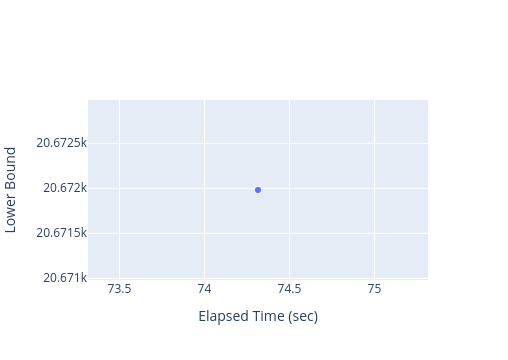

In [ ]:
hoovertext = [[],[]]
for d, device in enumerate(devices):
    for r in range(n_repeats):
        hoovertext[d].append(
            (f"num_fun_eval: {num_fun_eval[d,r]}<br>"
             f"num_iter: {num_iter[d,r]}<br>"
             f"elapsed_time_per_funcall: "
             f"{elapsed_times[d,r]/num_fun_eval[d,r]}"))

fig = go.Figure()
for d in range(len(devices)):
    trace = go.Scatter(x=elapsed_times[d,:], y=lower_bounds[d, :],
                       mode="markers", name=devices[d],
                       hovertext=hoovertext[d], hoverinfo="text")
    fig.add_trace(trace)
fig.update_layout(xaxis_title="Elapsed Time (sec)")
fig.update_layout(yaxis_title="Lower Bound")

fig